In [41]:
from random import random
from random import uniform
import math
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np

# PARTICLE AND SWARM CLASS FOR MOPSO

In [42]:
class Particle:
    def __init__(self,dim,bounds,x0,n_objective):
        self.position_i=np.zeros((1,dim))
        self.velocity_i=np.zeros((1,dim))      

        self.Functions = FuncClass()

        self.param=[-1 for c in range(0,n_objective)]
        
        self.bounds = bounds[0:8]
        
        self.pos_best_i=np.zeros((1,dim)) #pos_best_i contains the individual best position of the particle       

        self.bestparam_indiv=[-1 for c in range(0,n_objective)]       
        self.bestparam_global=[-1 for c in range(0,n_objective)]
     
        self.fitness = math.inf
        
        #array describing which parameter is maximised or minimised, 1==maximise, -1==minimise
        self.maxmin = []
        
        self.dim = dim 
        
        self.x0 = x0
        

        for i in range(0,self.dim): 
            self.velocity_i[0,i]=uniform(-1,1)
            self.position_i[0,i]=random.randint(int(self.bounds[i][0]), int(self.bounds[i][1]))      
    
    def check_dominated(self):
        dom = 0
        if self.param == self.bestparam_indiv:
            return 'tie'
        for i in range(len(self.param)):
            if (self.param[i] - self.bestparam_indiv[i])*self.maxmin[i]>0:
                dom+=1
        # print("dom_part: {}".format(dom))
        if dom == len(self.param):
            return 'dominated'
        else:
            return 'nondominated'

    def evaluate_fitness(self,arr):
        ideal = [i * 10000 for i in self.maxmin]
        fitness = 0
        for i in range(0,len(arr)):
            fitness = fitness + (ideal[i]-arr[i])**2
        return math.sqrt(fitness)
            
    def evaluate(self):
        self.param = self.Functions.evaluate(self.position_i)
        dom = self.check_dominated()        
        if dom =='dominated':
            self.pos_best_i = self.position_i
            self.bestparam_indiv= self.param
        elif dom == 'tie': 
            toss = random.uniform(0, 1) 
            if(toss>=0.5):
                self.pos_best_i = self.position_i
                self.bestparam_indiv= self.param
        self.fitness = self.evaluate_fitness(self.param)


    def update_velocity(self,pareto_arr,pareto_index,best_fitness):
        inertia = 0.4
        c1 = 3
        c2 = 1.5
        h = 0
        toss=random.uniform(0,1) 
        if(toss<0.8): # chooses from the fittest values with P=0.8
            h=random.randint(0, len(best_fitness)-1)
            h=best_fitness[h]
        else: #else chooses randomly from repo
            h=random.randint(0, len(pareto_index)-1)
            h=pareto_index[h]
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        V_personal_best=c1*r1*np.subtract(self.pos_best_i,self.position_i) #finds vector to the personal best
        V_global_best=c2*r2*np.subtract(pareto_arr[h,0:self.dim],self.position_i) #finds vector to one of the points on the repository decided by the toss                
        self.velocity_i=inertia*np.add(np.add(self.velocity_i,V_personal_best),V_global_best)        

    def update_postion(self): #updates position according to calculated velocity 
        for i in range(0,self.dim): 
            self.position_i[0,i]=self.position_i[0,i]+self.velocity_i[0,i]
            if self.position_i[0,i]>=self.bounds[i,1]: #prevents search space from exceeding the bound (upper limit)
                self.position_i[0,i]=self.bounds[i,1]       
            if self.position_i[0,i]<=self.bounds[i,0]: #prevents search space from exeeding the bound (lower limit)
                self.position_i[0,i]=self.bounds[i,0]
                
class SWARM:
    def __init__(self,x0,bounds,n_particles,iterations,dimension,FuncClass,no_of_objectives):
        self.paretonum=n_particles
        
        self.no_of_objectives = no_of_objectives
        
        self.allindex = list(range(self.paretonum))
        self.pareto_arr=np.zeros((self.paretonum,dimension+self.no_of_objectives+1))
        self.pareto_arr[:,dimension]=math.inf
        
        self.best_fitness=[]
        self.no_of_fitness = 5
        self.pareto_index=[]
        self.empty_index=[]
        self.particle_arr = []
        self.dim = dimension
        self.bounds = bounds
        self.x0 = x0
        self.n_particles = n_particles
        self.iterations = iterations
        for i in range(0,self.n_particles):
            particle = Particle(self.dim,self.bounds,self.x0,self.no_of_objectives)
            particle.Functions = FuncClass
            particle.maxmin = particle.Functions.maxmin
            particle.evaluate()
            self.pareto_arr[i,0:self.dim]=particle.position_i
            self.pareto_arr[i,dimension]=particle.fitness            
            for j in range(0,self.no_of_objectives):                
                self.pareto_arr[i,self.dim+j+1]=particle.param[j]                
            self.particle_arr.append(particle)
            self.pareto_index.append(i)
        self.empty_index=list(set(self.allindex)-set(self.pareto_index))
        
    def check_dominated(self,particle_param,paretopoint_param,maxmin):
        dom = 0
        for i in range(len(particle_param)):
            if (particle_param[i] - paretopoint_param[i])*maxmin[i]>0:
                dom+=1
        # print("dom_point {}".format(dom))
        if dom == len(particle_param):
            return True
        else:
            return False        
        
    def MOPSO(self):
        for iter in range(0,self.iterations):
            print("iteration {}".format(iter))
            #finds the index of the n (no_of_fitness) fittest rows in the pareto_arr
            self.best_fitness = np.argpartition(self.pareto_arr[:,self.dim],self.no_of_fitness)[0:self.no_of_fitness].tolist()
            
            for i in range(0,self.n_particles):
                self.particle_arr[i].evaluate()
                indices_dominated = []
                for j in self.pareto_index:
                    curr_parameter = self.pareto_arr[j,self.dim+1:self.dim+self.no_of_objectives+1]
                    if self.check_dominated(self.particle_arr[i].param,curr_parameter,self.particle_arr[i].maxmin):
                        indices_dominated.append(j)
                self.empty_index = self.empty_index + indices_dominated  
                if len(indices_dominated)!=0 and len(self.empty_index)!=0:
                    index_to_update = self.empty_index[0] 
                    self.pareto_arr[index_to_update,0:self.dim]=self.particle_arr[i].position_i
                    self.pareto_arr[index_to_update,self.dim]=self.particle_arr[i].fitness
                    for k in range(0,self.no_of_objectives):                
                        self.pareto_arr[index_to_update,self.dim+k+1]=self.particle_arr[i].param[k]                         
                    self.pareto_index.append(index_to_update)
                    self.empty_index.pop(0)                      
                self.particle_arr[i].update_velocity(self.pareto_arr,self.pareto_index,self.best_fitness)
                self.particle_arr[i].update_postion()                                
                self.pareto_index = [x for x in self.pareto_index if x not in indices_dominated]              
        if self.no_of_objectives == 1:
            plt.scatter(self.pareto_arr[:,0],self.pareto_arr[:,2])
        if self.no_of_objectives == 2:
            plt.scatter(self.pareto_arr[:,2],self.pareto_arr[:,3])            
        out = self.pareto_arr[np.argmin(self.pareto_arr[:,self.dim])]
        print("x_value: {}, optimised_values: {}".format(out[0],out[2:2+self.no_of_objectives]))

# TESTING SINGLE OBJECTIVE OPTIMISATION

In [43]:
#The function to be optimised is abs(((x[0,0]**2)/3) + ((x[0,0]**3+40)/30) + ((math.e**x[0,0]+50))/20)

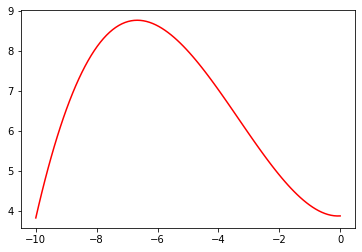

In [44]:
x = np.linspace(-10,0,100)
y = abs(((x**2)/3) + ((x**3+40)/30) + ((math.e**x+50))/20)
plt.plot(x,y, 'r')

from the graph plotted, the maximum point is at the peak where x = -6.667 and the corresponding y = 8.772. Now we will try to get to this maximum point using MOPSO

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
x_value: -6.669930303870634, optimised_values: [8.77166481]


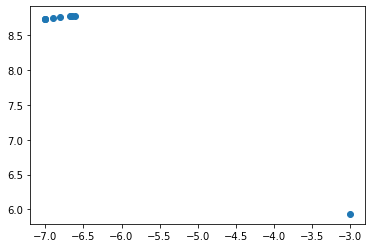

In [45]:
#defining FuncClass containing the function to be optimised
class FuncClass:
    def __init__(self):
        self.function_list = [self.function1]
        # maxmim corresponds to the function_list stating whether the function needs to be optimised +1 or minimised -1
        self.maxmin = [1]
    def function1(self,x):
        return abs(((x[0,0]**2)/3) + ((x[0,0]**3+40)/30) + ((math.e**x[0,0]+50))/20)
    def evaluate(self,x):
        ret = []
        for func in self.function_list:
            ret.append(func(x))
        return ret
Functions = FuncClass()

#The x value is bounded from -10 to 0
bounds = np.array([[-10,0]])
#initial value of the particle, optional
x0 =[2]   
swarm = SWARM(x0,bounds,10,10,1,Functions,1) 
swarm.MOPSO()

As seen above, after 9 iterations, the particle was able to converge close to the maximum point of 8.77 with the relevant x_value of -6.663 after 10 iterations.

# TESTING MULTIPLE OBJECTIVE OPTIMISATION

In a real world scenario, more than 2 functions might need to be optimised to come to a decision. 

In [46]:
# The 2 function to be optimised are abs(((x[0,0]**2)/3) + ((x[0,0]**3+40)/30) + ((math.e**x[0,0]+50))/20)
# and ((x[0,0]/3)+3)**3 

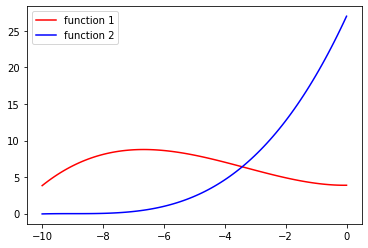

In [47]:
# Plotting the above 2 functions, we get
x = np.linspace(-10,0,100)
y = abs(((x**2)/3) + ((x**3+40)/30) + ((math.e**x+50))/20)
z = ((x/3)+3)**3 

plt.plot(x, y, 'r')
plt.plot(x, z, 'b')
plt.legend(["function 1", "function 2"])

In [48]:
#in the above optimisation scenario, we want to maximise function 1 while minimising function 2.

In [49]:
class FuncClass:
    def __init__(self):
        self.function_list = [self.function1, self.function2]
        #maximise function1 and minimise function2
        self.maxmin = [1,-1]
    def function1(self,x):
        return abs(((x[0,0]**2)/3) + ((x[0,0]**3+40)/30) + ((math.e**x[0,0]+50))/20)
    def function2(self,x):
        return ((x[0,0]/3)+3)**3 
    def evaluate(self,x):
        ret = []
        for func in self.function_list:
            ret.append(func(x))
        return ret

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
x_value: -7.0, optimised_values: [8.73337893 0.2962963 ]


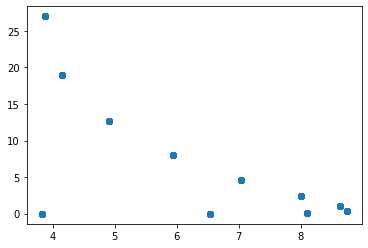

In [50]:
Functions = FuncClass()
bounds = np.array([[-10,0]])        
x0 =[2] 
swarm = SWARM(x0,bounds,1000,10,1,Functions,2)        
swarm.MOPSO()        

the paretofront fo the above optimisation is shown above and the optimal point was given to be x = -7 and y = 8.73 and z = 0.293. This corresponds to the peak of function 1 and the lower asymptotic value of z which can be visually observed to the optimal point for this mode of operation.

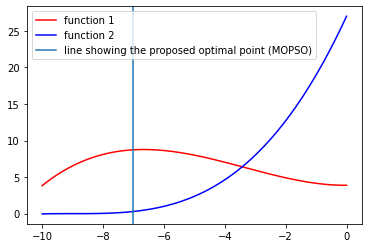

In [51]:
plt.plot(x, y, 'r')
plt.plot(x, z, 'b')
plt.axvline(x=-7)
plt.legend(["function 1", "function 2","line showing the proposed optimal point (MOPSO)"])

Now if we will try to maximise function2 and minimise function1 

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
x_value: 0.0, optimised_values: [ 3.88333333 27.        ]


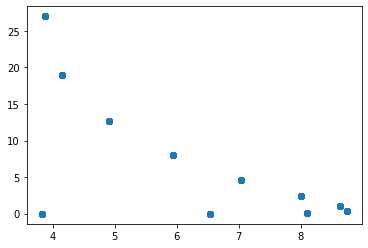

In [54]:
#As mentioned above, maxmin controls which parameters are maximised or minimised
Functions.maxmin = [-1,1]
swarm = SWARM(x0,bounds,1000,10,1,Functions,2)        
swarm.MOPSO()  

The paretofront obtained from running MOPSO is shown above. Now the particles converge at x=0

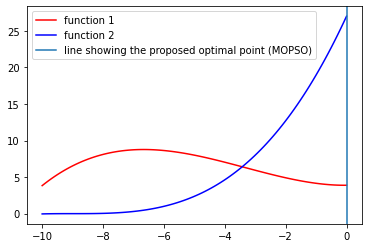

In [53]:
plt.plot(x, y, 'r')
plt.plot(x, z, 'b')
plt.axvline(x=0)
plt.legend(["function 1", "function 2","line showing the proposed optimal point (MOPSO)"])

x=0 does represent the point where function 2 is maximised and function 1 is minimised and we can see that the particles did indeed converge to the global optimal

For the sake of simplicity, the above examples only use a 1 dimensional solution space of x, however, the code has been written to be able to deal with a higher dimensional solution space. The code also adjusts between a single objective swarm as well as a multiple objective swarm. For Multiple Objective, only 2 objective functions were shown. However the code can handle a higher number of objectives. 